# Energy consumption prediction
* Brocco Mattia **|** 873058
* Piccolo Giulio **|** 874727

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

#import linear_model_tests as lmt
#import decision_tree_opt as dto
#import Data_viz as dv

#viz = dv.Graphs()
#lin_mod = lmt.Test()
#opt_tree = dto.Parameters()

%reload_ext autoreload
%autoreload 2

## DATA EXPLORATION AND CLEANSING

In [2]:
data = pd.read_csv(".\\data\\energydata_complete.csv", parse_dates = ["date"])
data = data.dropna()
names = ["date", "appliance_wh", "light_wh", "kitchen_celsius", "kitchen_hum_perc",
        "living_celsius", "living_hum_perc", "laundry_celsius", "laundry_hum_perc",
         "office_celsius", "office_hum_perc", "bathroom_celsius", "bathroom_hum_perc",
         "portico_celsius", "portico_hum_perc", "ironing_celsius", "ironing_hum_perc",
         "teen_celsius", "teen_hum_perc", "parents_celsius", "parents_hum_perc",
         "cws_celsius", "cws_pressure", "cws_hum_perc", "cws_wind", "cws_visibility",
         "cws_dew_point","rv1","rv2"]

data = data.rename(columns = dict(zip(data.columns, names)))
data = data.drop_duplicates(data.columns, keep = "last")

data = data.drop(["rv1", "rv2"], axis = 1)

print(data.shape)

(19735, 27)


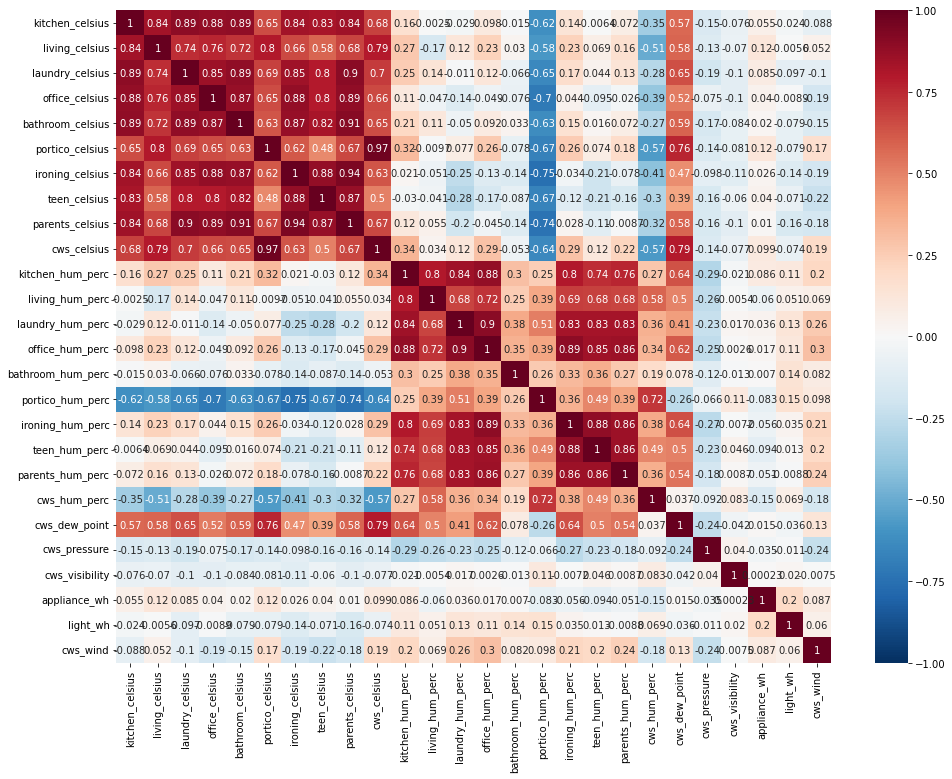

In [3]:
plt.figure(figsize = (16, 12))
# Correlation matrix grouping variables in temperature-related
# and humidity related. This highlights the block of variables
# that are highly correlated with each other.
sns.heatmap(data[sorted(data.columns, key = lambda s: s.split("_")[-1])].corr(),
            annot = True, cmap = "RdBu_r", vmin = -1, vmax = 1)
plt.show()

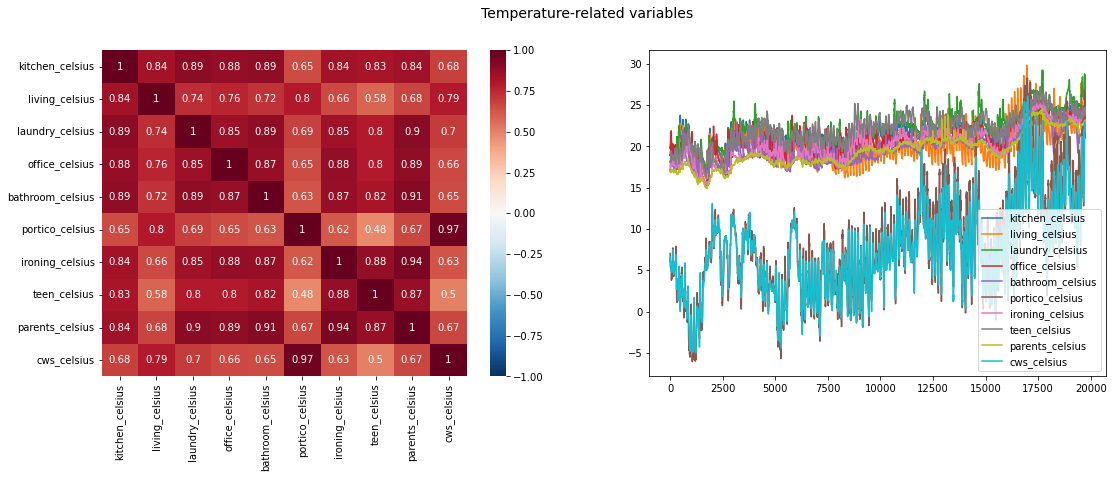

Variance
kitchen_celsius      2.579447
living_celsius       4.809133
laundry_celsius      4.024479
office_celsius       4.173377
bathroom_celsius     3.402635
portico_celsius     37.092322
ironing_celsius      4.452072
teen_celsius         3.826569
parents_celsius      4.059066
cws_celsius         28.274836
dtype: float64


In [4]:
# Intial features selection due to high collinearity
# TEMPERATURES
t_fig, t_ax = plt.subplots(1, 2, figsize = (18, 6))
sns.heatmap(data[[c for c in data.columns if "celsius" in c]].corr(),
            annot = True, cmap = "RdBu_r", vmin = -1, vmax = 1, ax = t_ax[0])


data[[c for c in data.columns if "celsius" in c]].plot(ax = t_ax[1])#.mean(axis = 1)
plt.suptitle("Temperature-related variables", fontsize = 14)
plt.show()

print("Variance")
print(data[[c for c in data.columns if "celsius" in c]].var())

###
# Introductory removal of features
# Remove: 'portico_celsius', 0.97 correlation with 'cws_celsius'
data = data.drop("portico_celsius", axis = 1)
###

# KEEP: cws_celsius (temperature measured by Chievres Weather Station)

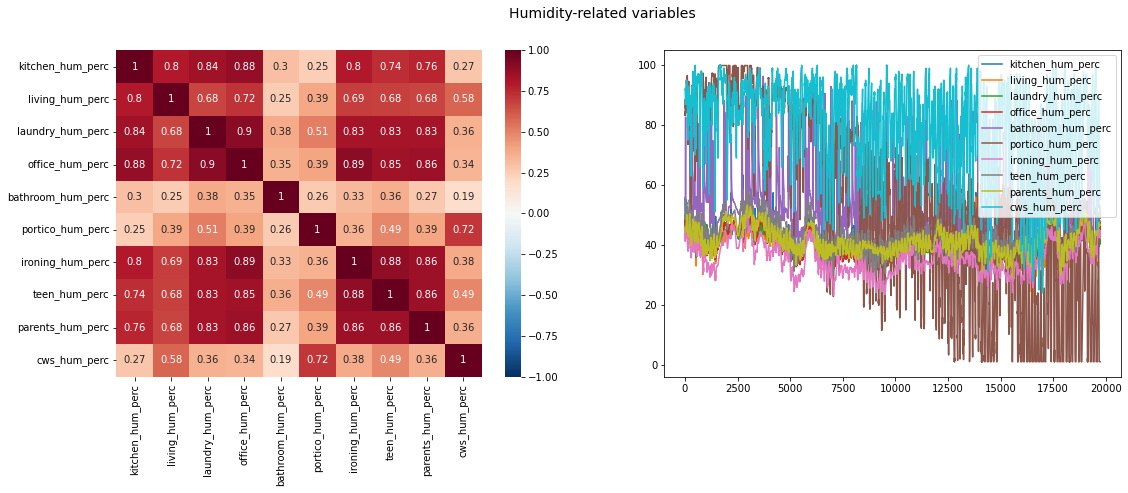

Variance
kitchen_hum_perc      15.834819
living_hum_perc       16.563374
laundry_hum_perc      10.592268
office_hum_perc       18.847065
bathroom_hum_perc     81.397103
portico_hum_perc     970.310406
ironing_hum_perc      26.155124
teen_hum_perc         27.293945
parents_hum_perc      17.234930
cws_hum_perc         222.042410
dtype: float64


In [5]:
# Intial features selection due to high collinearity
# PERCENTAGE OF HUMIDITY
h_fig, h_ax = plt.subplots(1, 2, figsize = (18, 6))
sns.heatmap(data[[c for c in data.columns if "hum_perc" in c]].corr(),
            annot = True, cmap = "RdBu_r", vmin = -1, vmax = 1, ax = h_ax[0])


data[[c for c in data.columns if "hum_perc" in c]].plot(ax = h_ax[1])#.mean(axis = 1)
plt.suptitle("Humidity-related variables", fontsize = 14)
plt.show()

print("Variance")
print(data[[c for c in data.columns if "hum_perc" in c]].var())

# KEEP: cws_celsius (temperature measured by Chievres Weather Station)

## PCA to reduce the number of features

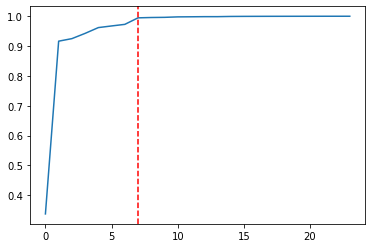

In [6]:
from sklearn.decomposition import PCA

X = data.drop(["date", "appliance_wh"], axis = 1)
y = np.log(data.appliance_wh)

pca = PCA(n_components = X.shape[1], random_state = 42)
pca.fit(X)

plt.plot(1 - pca.explained_variance_ratio_)
plt.axvline(7, ls = "--", color = "red")

pca7 = PCA(n_components = 7, random_state = 42)
pca7.fit(X)

X_rid = pca7.transform(X)

### Target, Features and Train Size
Set the target and the features matrices, with the train size equal to the 70% of the sample size

In [7]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_rid, y, train_size = 0.7,
                                                    random_state = 42, shuffle = True)

X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, train_size = 0.7,
                                                              random_state = 42, shuffle = True)

## LINEAR MODELS
* Linear Regression
* Lasso
* Support Vector Regressor

Linear regression R^2: 0.15002					Lasso R^2: 0.14997
Linear regression MSE: 0.37107					Lasso MSE: 0.37109


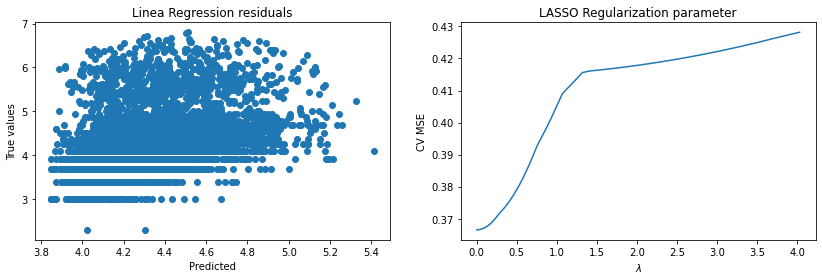

In [9]:
lr = LinearRegression(fit_intercept = True, n_jobs = -1)
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)

#lin_par = opt_tree.evaluate(y_test, y_pred)

#lasso = lin_mod.lasso(data, X)
#recursive = lin_mod.recurs_elimin(data, X, y)
#viz.plot_2(data, model, lasso, recursive)
lasso_fig, lasso_ax = plt.subplots(1, 2, figsize = (14, 4))
lasso_ax[0].scatter(lr_pred, y_test)
lasso_ax[0].set_xlabel("Predicted")
lasso_ax[0].set_ylabel("True values")
lasso_ax[0].set_title("Linea Regression residuals")

lasso = LassoCV(cv = 10, n_jobs = -1, random_state = 42)
lasso.fit(X_train, y_train)

lasso_ax[1].plot(lasso.alphas_, lasso.mse_path_.mean(axis = 1))
lasso_ax[1].set_xlabel("$\lambda$")
lasso_ax[1].set_ylabel("CV MSE")
lasso_ax[1].set_title("LASSO Regularization parameter")

print("Linear regression R^2: {:.5f}\t\t\t\t\tLasso R^2: {:.5f}".format(r2_score(y_test, lr_pred),
                                                                        r2_score(y_test, lasso.predict(X_test))))
print("Linear regression MSE: {:.5f}\t\t\t\t\tLasso MSE: {:.5f}".format(mean_squared_error(y_test, lr_pred),
                                                                        mean_squared_error(y_test, lasso.predict(X_test))))

plt.show()

In [10]:
supp = SVR(kernel = "rbf")
supp.fit(X_train, y_train)
print("R^2: ", round(r2_score(y_test, supp.predict(X_test)), 5) )

svr_hyperparam = {"C":[1, 5, 10, 15]}
svr_grid = GridSearchCV(SVR(kernel = "rbf"), svr_hyperparam,
                        n_jobs = -1, cv = 3, verbose = 10,
                        return_train_score = True)

svr_grid.fit(X_train, y_train)

print("R^2: {:.5f}".format(mean_squared_error(y_test, svr_grid.best_estimator_.predict(X_test))) )
##supp_par = opt_tree.evaluate(y_test, supp.predict(X_test))

R^2:  0.22669
Fitting 3 folds for each of 4 candidates, totalling 12 fits
R^2: 0.31231


From the consideration of these linear models, by interpreting the problem at hand as a regression one, one can notice that, given the high amount of collinearity, the problem looks non-linear.

## DECISION TREE REGRESSOR

In [14]:
dt1 = DecisionTreeRegressor(random_state = 42)
dt2 = DecisionTreeRegressor(random_state = 42)

dt1.fit(X_train, y_train)
dt2.fit(X_train_full, y_train)

# EX-POST PRUNING

for n, tree in enumerate([dt1, dt2]):

    # Compute impurities to look for an adequate pruning term
    path = tree.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    # Plot the impurity level given ccp_alpha
    #plt.plot(ccp_alphas[:-1], impurities[:-1], marker = "o", drawstyle = "steps-post")
    #plt.xlabel("effective alpha")
    #plt.ylabel("total impurity of leaves")
    #plt.title("Total Impurity vs effective alpha for training set")
    #plt.show()

    # Tree Pruning (we are overfitting - Accuracy: 100% in training)
    tree_params = {"ccp_alpha":[ccp_alphas[impurities < impty].max()
                                for impty in np.linspace(0.1, np.round(impurities.max()/2, 3),
                                                         num = 5)]}

    tree_grid = GridSearchCV(DecisionTreeRegressor(random_state = 42),
                             tree_params, cv = 3, n_jobs = 6, verbose = 10,
                             return_train_score = True)
    if n == 0:
        tree_grid.fit(X_train, y_train)
        # Show the results
        print("With 7 features")
        print("MSE: {:.5f}".format(mean_squared_error(y_test, tree_grid.best_estimator_.predict(X_test))))
    else:
        print()
        print("With all features")
        tree_grid.fit(X_train_full, y_train)
        print("MSE: {:.5f}".format(mean_squared_error(y_test, tree_grid.best_estimator_.predict(X_test_full))))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
With 7 features
MSE: 0.30755

With all features
Fitting 3 folds for each of 5 candidates, totalling 15 fits
MSE: 0.26800


In [15]:
# FROM HERE !!!!!!!!!!!!!!!!!!!

### AdaBoosting and Bagging of the Tree Regressor

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
adaboost = AdaBoostRegressor(base_estimator = tree_tuned, loss = "linear", random_state = 981, learning_rate = 0.001)
boost_model = adaboost.fit(X_train, y_train)
adaboost_pred = boost_model.predict(X_test)

tuned_par = opt_tree.evaluate(y_test, adaboost_pred)

In [ ]:
from sklearn.ensemble import BaggingRegressor

bagged = BaggingRegressor(base_estimator = tree_tuned, random_state = 981)
bagg_model = bagged.fit(X_train, y_train)
bagg_pred = bagg_model.predict(X_test)

tuned_par = opt_tree.evaluate(y_test, bagg_pred)

## RANDOM FOREST REGRESSOR

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 1000, random_state = 1234)
rf_model = rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

rf_par = opt_tree.evaluate(y_test, rf_pred)
rf_imp = opt_tree.dtr_importance(data, rf_model)
print("Parameters currently in use:")
pprint(rf.get_params())

### Selection of the 8 most important features

In [ ]:
imp_feats = ["living_celsius", "teen_hum_perc", "parents_hum_perc", "kitchen_hum_perc",
             "bathroom_hum_perc", "laundry_hum_perc", "teen_celsius", "portico_hum_perc"]
feat_drop = [x for x in data.columns if x not in imp_feats]

X_rf = data.drop(feat_drop, axis = 1).values
X_rf = X_rf.reshape( (len(X_rf), len(X_rf[0])))

X_train_rf =  X_rf[:train_size]
X_test_rf = X_rf[train_size:]

### Parameter tuning for Random Forest Regressor

Chunk 1: Parameters are chosen after RandomizedSearchCV

In [ ]:
rf_tuned = RandomForestRegressor(n_estimators = 1000, min_samples_split = 5, min_samples_leaf = 1,
                                 max_features = 'sqrt', max_depth = None, bootstrap = False, random_state = 756)
model_rf_tuned = rf_tuned.fit(X_train_rf, y_train)
rf_tuned_pred = model_rf_tuned.predict(X_test_rf)

tuned_par_rf = opt_tree.evaluate(y_test, rf_tuned_pred)

Chunk 2: Parameters are chosen after GridSearchCV

In [ ]:
rf_tun_2 = RandomForestRegressor(n_estimators = 800, min_samples_split = 2, min_samples_leaf = 1,
                                 max_features = 'sqrt', max_depth = None, bootstrap = False, random_state = 234)
model_rf_tun_2 = rf_tun_2.fit(X_train_rf, y_train)
rf_tun_2_pred = model_rf_tun_2.predict(X_test_rf)

tuned_par_rf = opt_tree.evaluate(y_test, rf_tun_2_pred)

## Forest with ```LightGBM```

In [ ]:
import lightgbm as lgb
lgb_train = lgb.Dataset(X_train_rf, y_train)
lgb_eval = lgb.Dataset(X_test_rf, y_test, reference = lgb_train)

forest = lgb.LGBMRegressor(boosting_type = 'rf', objective = "regression", metric = ["l1","l2"],
                           num_leaves = 300, max_depth = 500, learning_rate = 0.0001, num_iterations = 600,
                           feature_fraction = 0.9, bagging_fraction = 0.8, bagging_freq = 5, verbose = 0,
                           min_child_weight = 30, min_split_gain = 0.001, random_state = 1234)

forest.fit(X_train_rf, y_train)
for_pred = forest.predict(X_test_rf)

for_par = opt_tree.evaluate(y_test, for_pred)

### Bayesian optimization

In [ ]:
# fine tuning hyperparameters
def hyp_lgbm(num_leaves, feature_fraction, bagging_fraction, max_depth, min_split_gain, min_child_weight):
    # Default parameters
    params = {"application" : "regression", "num_iterations" : 5000,
              "learning_rate" : 0.05, "early_stopping_round" : 50, "metric" : 'l1'}
    
    # Add parameters 
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    
    # Cross Validation
    cv_result = lgb.cv(params, lgb_train, nfold = 5, seed = 7, stratified = False, verbose_eval = None, metrics = ["l1"])
    return -np.min(cv_result['l1-mean']) # negative of l1

In [ ]:
from bayes_opt import BayesianOptimization
pds = { "num_leaves": (300, 500), "feature_fraction": (0.1, 0.9), "bagging_fraction": (0.8, 1),
        "max_depth": (500, 1000), "min_split_gain": (0.001, 0.1), "min_child_weight": (30, 50) }
# Surrogate model
optimizer = BayesianOptimization(hyp_lgbm, pds)

In [ ]:
from bayes_opt import BayesianOptimization
pds = { "num_leaves": (300, 500), "feature_fraction": (0.1, 0.9), "bagging_fraction": (0.8, 1),
        "max_depth": (500, 1000), "min_split_gain": (0.001, 0.1), "min_child_weight": (30, 50) }
# Surrogate model
optimizer = BayesianOptimization(hyp_lgbm, pds)
                                  
# Optimize
optimizer.maximize(init_points = 5, n_iter = 15)
optimizer.max["params"]

In [ ]:
forest_2 = lgb.LGBMRegressor(boosting_type = 'rf', objective = "regression", metric = ['l2', 'l1'],
                             num_leaves = 440, max_depth = 752, random_state = 1234,
                             learning_rate = 0.0001, num_iterations = 600, feature_fraction = 0.30908802314596395,
                             bagging_fraction = 0.8376848054627992, bagging_freq = 5, verbose = 0,
                             min_child_weight = 30.803558747467385, min_split_gain = 0.08407521026838967)

forest_2.fit(X_train_rf, y_train)
for_pred_2 = forest_2.predict(X_test_rf)

for_par_2 = opt_tree.evaluate(y_test, for_pred_2)

-----------------------------------------
-----------------------------------------